# This notebook aims to build and train a model to classify traffic signs.
author: Marcelo Garcia

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.applications import InceptionV3
from keras import Sequential
from keras.layers import Activation, Cropping2D, Lambda, Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras.models import load_model
from keras.models import model_from_json
from keras.optimizers import Adam
from keras import backend as K

%matplotlib inline

In [4]:
## importing all data into a pandas dataframe
green_paths = glob.glob("./simulator_dataset/green/*.jpg")
red_paths = glob.glob("./simulator_dataset/red/*.jpg")
yellow_paths = glob.glob("./simulator_dataset/yellow/*.jpg")
none_paths = glob.glob("./simulator_dataset/none/*.jpg")
green_df = pd.DataFrame({'image_path':green_paths, 'labels':np.array(['green']*len(green_paths))})
red_df = pd.DataFrame({'image_path':red_paths, 'labels':np.array(['red']*len(red_paths))})
yellow_df = pd.DataFrame({'image_path':yellow_paths, 'labels':np.array(['yellow']*len(yellow_paths))})
none_df = pd.DataFrame({'image_path':none_paths, 'labels':np.array(['none']*len(none_paths))})
df = pd.concat([green_df, red_df, yellow_df, none_df], ignore_index=True)
df['image_path'] = df['image_path'].str.replace('\\','/')
print(f"Dataset lenght: {len(df)}")

Dataset lenght: 1324


In [4]:
# one hot encode
df = pd.concat([df,pd.get_dummies(df['labels'])], axis = 1)
df.head()

,image_path,labels,green,none,red,yellow
0,./simulator_dataset/green/00dc2e66-6ed7-466a-8...,green,1,0,0,0
1,./simulator_dataset/green/012274e6-2cf2-4262-8...,green,1,0,0,0
2,./simulator_dataset/green/020b8e3d-abe8-429c-9...,green,1,0,0,0
3,./simulator_dataset/green/033b5138-66f9-48cd-9...,green,1,0,0,0
4,./simulator_dataset/green/0528103e-969c-4047-b...,green,1,0,0,0


In [6]:
def img_thresh(path):
    im = cv2.imread(path)
    #shifted = cv2.pyrMeanShiftFiltering(im, 21, 51)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh[thresh==255]=1
    im[thresh!=1]=0
    im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    hsv_img = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    v = hsv_img[:, :, 2]
    im[v<240]=0
    return im

In [7]:
def get_images(image_paths:np.array):
    """
        This functions gets a numpy array of image paths and returns
        a numpy array of RGB images
    """
    images = []
    for path in image_paths:
        im=cv2.resize(img_thresh(path),(299,299))
        images.append(im)
        #images.append(cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB),(299,299)))
    return np.array(images)

In [8]:
# Visualize an image of each label
visualize_df = df.groupby('labels').first().reset_index()
visualize_df

,labels,image_path
0,green,./simulator_dataset/green/00dc2e66-6ed7-466a-8...
1,none,./simulator_dataset/none/002aa9a8-a717-4b41-82...
2,red,./simulator_dataset/red/008af707-1ef9-42df-b63...
3,yellow,./simulator_dataset/yellow/02bf3421-a047-461d-...


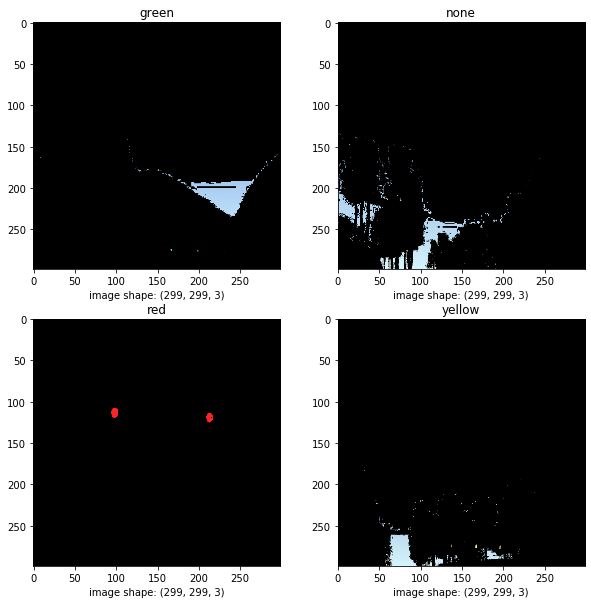

In [9]:
plt.figure(figsize=(10,10))
for i, image in enumerate(get_images(visualize_df['image_path'])):
    plt.subplot(2,2,i+1)
    plt.imshow(image)
    plt.xlabel(f'image shape: {image.shape}')
    plt.title(visualize_df['labels'][i])

In [8]:
def batch_generator(dataframe: pd.core.frame.DataFrame, batch_size: int):
    """
        This generator creates batches from all dataframe based on the batch size
        
        @params dataframe: pandas dataframe that contains all data and steering labels 
        @params batch_size: integer that sets the number of batches to which our data will be split on
        @yield batch: each iteration our generator yields a random batch
    """
    
    if type(dataframe) != pd.core.frame.DataFrame:
        raise ValueError('the input to batch_generator is not a pandas dataframe')
    minVal = np.min(dataframe[['green', 'none', 'red', 'yellow']].sum())
    while 1: # Loop forever so the generator never terminates
        randGreen = dataframe[dataframe['green']==1].sample(minVal)
        randRed = dataframe[dataframe['red']==1].sample(minVal)
        randYellow = dataframe[dataframe['yellow']==1].sample(minVal)
        randNone = dataframe[dataframe['none']==1].sample(minVal)
        rand_df = pd.concat([randGreen, randRed, randYellow, randNone], ignore_index=True)
        temp_df = rand_df.sample(batch_size)
        # getting labels
        labels =  temp_df[['green','none','red', 'yellow']].values
        # getting image paths for the 3 cameras
        img_paths = np.array(temp_df['image_path'])
        # getting images from image paths
        images = get_images(img_paths)
        
        batch_Y = labels
        batch_X = images
        yield shuffle(batch_X, batch_Y)

### Let's split data into training and validation

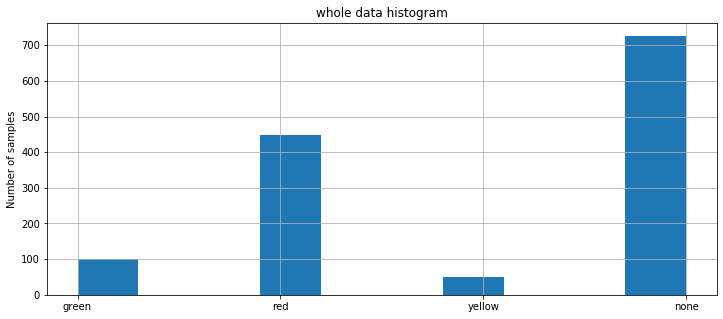

In [11]:
plt.figure(figsize=(12,5))
df['labels'].hist();
plt.title('whole data histogram');
plt.ylabel('Number of samples');

In [12]:
train_df, validation_df  = train_test_split(df,
                                            stratify=df['labels'], 
                                            test_size=0.2)

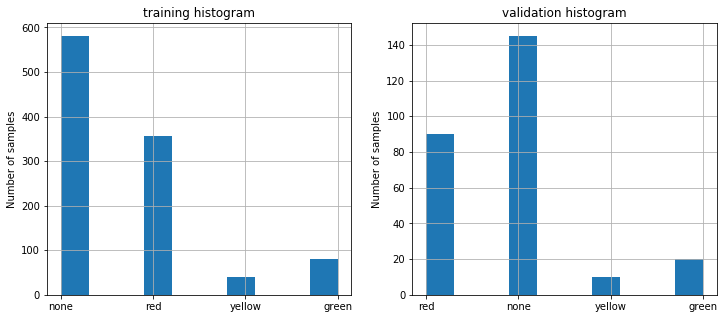

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(121)
train_df['labels'].hist();
plt.title('training histogram');
plt.ylabel('Number of samples')
plt.subplot(122)
validation_df['labels'].hist();
plt.title('validation histogram');
plt.ylabel('Number of samples');

### Creating generators

In [13]:
batch_size = 10
val_generator = batch_generator(validation_df, batch_size)
train_generator = batch_generator(train_df, batch_size)

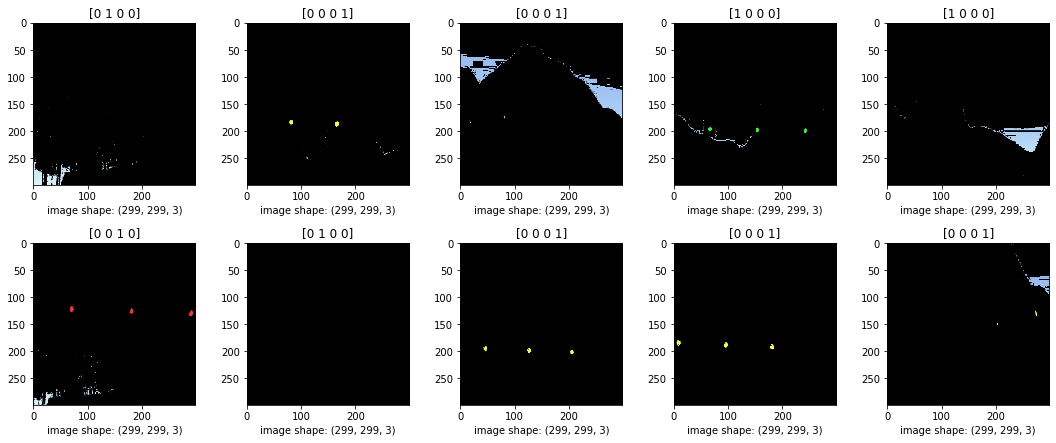

In [435]:
## Testing images
images, labels = next(train_generator)
fig = plt.figure(figsize=(15,15))
i=1
for img, label in zip(images, labels):
    plt.subplot(5,5,i)
    i=i+1
    plt.imshow(img)
    plt.title(str(label))
    plt.xlabel(f'image shape: {img.shape}')
fig.tight_layout()
plt.show()

## Build Model

In [18]:
## simple model
model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(299,299,3)))
# Start architecture here
model.add(Conv2D(24,kernel_size=(5,5),strides=(1,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(36,kernel_size=(5,5),strides=(1,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(48,kernel_size=(5,5),strides=(1,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dropout(0.6))
model.add(Dense(2000,activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(4))
model.add(Lambda(lambda x: K.tf.nn.softmax(x)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 295, 295, 24)      1824      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 24)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 69, 69, 36)        21636     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 36)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 48)        43248     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 48)          0         
__________

In [37]:
## Run model
model_path="weights.h5"

checkpoint = ModelCheckpoint(model_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True,
                              period=1)

early_stop = EarlyStopping(monitor='val_loss', 
                       mode= 'min', 
                       patience=7)

lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=0, verbose=2, mode='min')



callbacks_list = [checkpoint, early_stop, lr_reduce]
lr = 1e-3
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
history=model.fit_generator(train_generator, 
            steps_per_epoch=np.ceil(100), 
            validation_data=val_generator, 
            validation_steps=np.ceil(45), 
            epochs=1, verbose=1, callbacks=callbacks_list)

Epoch 1/1
100/100 [==============================] - 156s 2s/step - loss: 1.2711 - acc: 0.3170 - val_loss: 1.0937 - val_acc: 0.4933

Epoch 00001: val_loss improved from inf to 1.09370, saving model to weights2.h5


### Save model architecture

In [20]:
## Just save model architecture to a .json:
def save_arch():
    model_json = model.to_json()
    with open("my_model.json", "w") as json_file:
        json_file.write(model_json)

### Load model

In [7]:
model_path = 'my_model.json' #path to saved model
weight_path = 'weights.h5' #path to saved best weights

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    json_model = open(model_path, 'r')
    loaded_model_json = json_model.read()
    json_model.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(weight_path)
    return model

loaded_model = load_model(model_path, weight_path)
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 299, 299, 3)       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 295, 295, 24)      1824      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 24)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 69, 69, 36)        21636     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 36)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 13, 13, 48)        43248     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 48)          0         
__________

#### Inference with loaded model

In [28]:
def traffic_state(predictions):
    top_index = np.argmax(result,axis=1)
    statesDic={0:'green',1:'none',2:'red',3:'yellow'}
    return [statesDic[top] for top in top_index]
        

In [33]:
visualize_df = df.groupby('labels').tail(50).reset_index()
imgs = get_images(visualize_df[visualize_df['green']==1]['image_path'])
result = loaded_model.predict(imgs)
result_state = traffic_state(result)
print(result)
print("detected traffic light states")
print(result_state)

[[1.00000000e+00 0.00000000e+00 1.71762693e-29 1.14650067e-31]
 [1.00000000e+00 3.04999354e-29 1.40445797e-18 4.22421121e-18]
 [1.00000000e+00 7.01160929e-22 2.68340471e-13 1.53922372e-15]
 [1.00000000e+00 1.01191578e-36 1.35596872e-22 2.40992589e-24]
 [1.00000000e+00 1.54675235e-37 5.54771607e-23 2.96602234e-25]
 [1.00000000e+00 7.27587198e-34 2.82993412e-21 3.23288679e-20]
 [9.95683074e-01 1.01896485e-05 2.26857932e-03 2.03806395e-03]
 [1.00000000e+00 5.05444880e-32 2.08504147e-19 1.10321259e-19]
 [9.95304346e-01 1.10170295e-05 4.35319124e-03 3.31519812e-04]
 [9.95263219e-01 5.74721307e-05 3.24649597e-03 1.43291720e-03]
 [9.99998093e-01 1.10366016e-09 1.75223636e-06 1.47252607e-07]
 [4.70783561e-01 2.04785377e-01 3.16832006e-01 7.59916287e-03]
 [4.29617673e-01 1.60713688e-01 3.68918985e-01 4.07496579e-02]
 [1.00000000e+00 7.64908919e-25 2.82345135e-15 2.35693085e-16]
 [1.00000000e+00 1.16833020e-36 1.74016859e-22 5.45955802e-24]
 [9.85885859e-01 1.05926767e-04 6.61628274e-03 7.391918

## Testing other filters

In [244]:
def color_filter(path):
    image = cv2.imread(path)
    result = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower = np.array([0,25,0])
    upper = np.array([10,255,255])
    mask = cv2.inRange(image, lower, upper)
    result = cv2.bitwise_and(result, result, mask=mask)
    image[result==0]=0
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

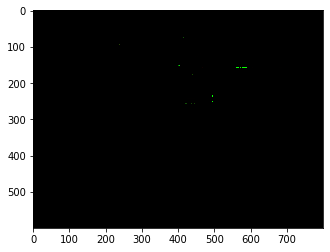

In [245]:
color_filter(img_path)

In [445]:
# Visualize an image of each label
visualize_df = df.groupby('labels').tail(50).reset_index()
list(visualize_df['image_path'])

['./simulator_dataset/green/814c613f-4943-4f4b-8586-f864764ad0ee.jpg',
 './simulator_dataset/green/81cbf027-8088-42cf-96ec-23e31d72889f.jpg',
 './simulator_dataset/green/846fd8e0-2366-4381-bbc1-636db86e947c.jpg',
 './simulator_dataset/green/864aceae-9c34-4483-9434-408d3f06cf80.jpg',
 './simulator_dataset/green/88215090-0181-47ed-b24e-88e2b563c279.jpg',
 './simulator_dataset/green/8b639710-e2bf-4e45-820b-926ef9c0b0a6.jpg',
 './simulator_dataset/green/90229b90-2687-4d78-84e2-aafe32143474.jpg',
 './simulator_dataset/green/90b08d75-f7c8-44ff-81d6-07538366c4e9.jpg',
 './simulator_dataset/green/914d8a9f-961e-4abb-8704-1c95e57c1af6.jpg',
 './simulator_dataset/green/91648f99-b243-4cfd-b973-3aa971a20aef.jpg',
 './simulator_dataset/green/94e987b4-2c96-4cfa-916c-6e46239352e6.jpg',
 './simulator_dataset/green/96752047-fb42-460b-b34e-b19b83c980f1.jpg',
 './simulator_dataset/green/98f67ebe-44b5-4116-ae16-30459a06bec2.jpg',
 './simulator_dataset/green/9a36f59c-a998-48b3-a340-b232e776ff60.jpg',
 './si

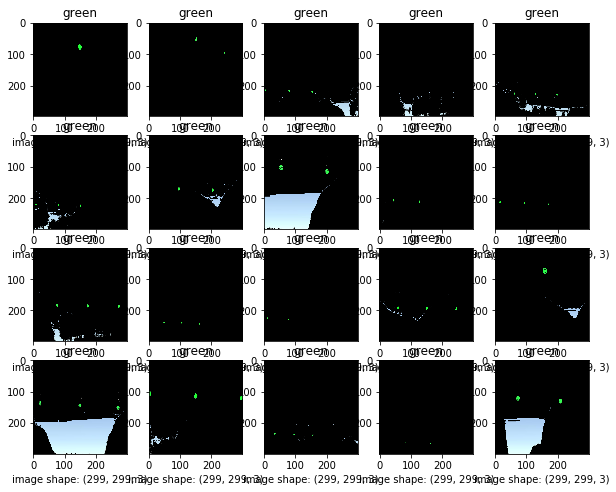

In [444]:
plt.figure(figsize=(10,10))
for i, image in enumerate(get_images(visualize_df[visualize_df['green']==1]['image_path'])):
    plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.xlabel(f'image shape: {image.shape}')
    plt.title(visualize_df['labels'][i])

## Inference when input is an RGB image

In [137]:
def preprocess(img):
    rgb_image = img.copy()
    gray = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh[thresh==255]=1
    rgb_image[thresh!=1]=0
    hsv_img = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    v = hsv_img[:, :, 2]
    rgb_image[v<240]=0
    return np.expand_dims(cv2.resize(rgb_image,(299,299)), axis=0)

In [25]:
def traffic_state(predictions):
    top_index = np.argmax(result,axis=1)
    statesDic={0:'green',1:'none',2:'red',3:'yellow'}
    return [statesDic[top] for top in top_index]

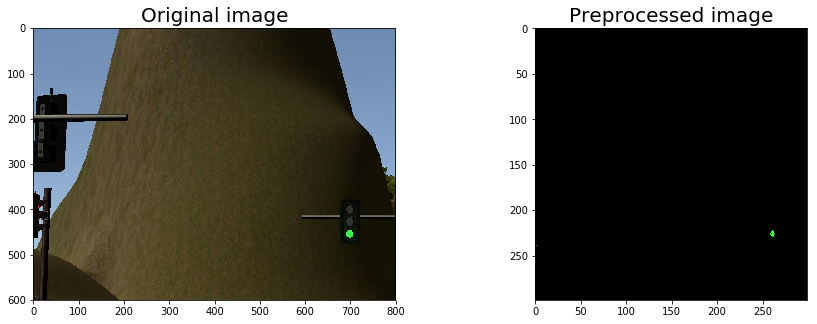

In [163]:
image = cv2.imread('./simulator_dataset/green/94e987b4-2c96-4cfa-916c-6e46239352e6.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
pp_image = preprocess(image)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(image)
plt.title('Original image', fontsize=20)
plt.subplot(122)
plt.imshow(pp_image[0])
plt.title('Preprocessed image', fontsize=20);

In [164]:
result = loaded_model.predict(pp_image)
print(traffic_state(result))

['green']


### Let's see if it works even with no preprocessing

In [23]:
def test(rgb_image):
    rgb_image = cv2.cvtColor(rgb_image,cv2.COLOR_BGR2RGB)
    return np.expand_dims(cv2.resize(rgb_image,(299,299)), axis=0)

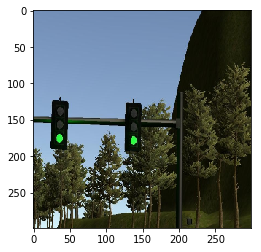

In [151]:
image = cv2.imread('./simulator_dataset/green/556047cb-235e-481a-8c13-9245a96689c2.jpg')
tes = test(image)
plt.imshow(tes[0]);

In [152]:
result = loaded_model.predict(tes)
print(traffic_state(result))

['green']


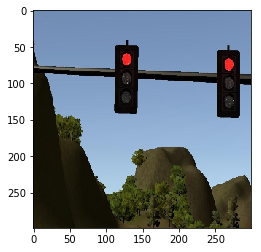

In [153]:
image = cv2.imread('./simulator_dataset/red/6d366f87-d0b1-4f42-8c22-3febf6283679.jpg')
tes = test(image)
plt.imshow(tes[0]);

In [154]:
result = loaded_model.predict(tes)
print(traffic_state(result))

['red']


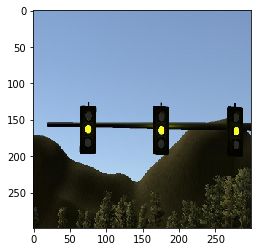

In [155]:
image = cv2.imread('./simulator_dataset/yellow/2e5b095a-14b9-4c92-acae-3ab1c1450987.jpg')
tes = test(image)
plt.imshow(tes[0]);

In [156]:
result = loaded_model.predict(tes)
print(traffic_state(result))

['yellow']


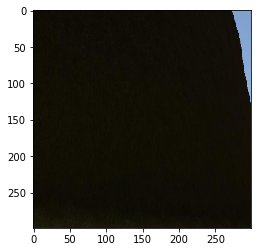

In [157]:
image = cv2.imread('./simulator_dataset/none/2e2e6d59-7dc2-40d9-b0ee-927176e03a71.jpg')
tes = test(image)
plt.imshow(tes[0]);

In [158]:
result = loaded_model.predict(tes)
print(traffic_state(result))

['none']


**Conclusion** it predicts even without preprocessing! However, preprocessing was crucial for training the network